# **Sentimen Analisis Review APK Play Store**

# **Import Library**

Pertama-tama, kita menginstal dan mengimpor berbagai pustaka yang akan digunakan, mulai dari pustaka untuk analisis data, pemrosesan teks, hingga algoritma machine learning.

In [ ]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.5 MB/s eta 0:00:00


In [ ]:
# Import library yang dibutuhkan
import os
import re
import string
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import requests
from io import StringIO

# Konfigurasi pandas untuk menonaktifkan peringatan chaining
pd.options.mode.chained_assignment = None

# Mengatur seed untuk reproduktibilitas
seed = 0
np.random.seed(seed)

# Import pustaka NLTK (Natural Language Toolkit)
import nltk
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks
nltk.download('punkt_tab')
nltk.download('stopwords')  # Mengunduh daftar kata-kata berhenti (stop words) dalam berbagai bahasa

# Import library pemrosesan teks
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Import library untuk pemrosesan bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Import library untuk visualisasi data
from wordcloud import WordCloud

# Import library untuk machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Import library untuk deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, SpatialDropout1D,
    Conv1D, GlobalMaxPooling1D, Bidirectional, MaxPooling1D,
    Flatten, GRU, SimpleRNN
)
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Sekarang, kita perlu mengakses dataset ulasan pengguna Gojek yang telah dikumpulkan dari Play Store. Karena data ini disimpan di Google Drive, kita harus membuka jalur aksesnya agar dapat digunakan dalam analisis.

Google Colab memungkinkan kita untuk langsung mengakses file di Drive dengan fitur mounting, sehingga kita bisa membaca, memanipulasi, dan menganalisis data tanpa perlu mengunduhnya terlebih dahulu.

In [ ]:
# Mount Google Drive (hanya untuk Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Karena kita bekerja di Google Drive, kita harus berpindah ke folder yang berisi dataset agar lebih mudah mengaksesnya. Namun, sebelum melangkah, kita harus memeriksa apakah folder tersebut benar-benar ada.

In [ ]:
# Tentukan path tujuan
target_path = '/content/drive/MyDrive/Laskar AI/BPML'

# Periksa apakah path ada sebelum berpindah
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Berhasil berpindah ke: {os.getcwd()}")
else:
    print(f"Path tidak ditemukan: {target_path}. Periksa kembali lokasi foldernya.")

Berhasil berpindah ke: /content/drive/MyDrive/Laskar AI/BPML


# Loading Dataset

Langkah pertama dalam eksplorasi ini adalah memuat dataset ulasan aplikasi Gojek yang telah dikumpulkan. Dataset ini berisi berbagai komentar pengguna tentang pengalaman mereka dalam menggunakan aplikasi. Dengan memuat dataset ini, kita akan melihat gambaran awal tentang apa yang dikatakan pengguna.

In [ ]:
df_gojek_reviews = pd.read_csv('data/ulasan_aplikasi_gojek_30K.csv')

Sebelum menyelam lebih dalam, kita perlu memahami seberapa besar dataset yang kita miliki. Ini seperti melihat peta sebelum menjelajahi sebuah kota—kita perlu tahu seberapa luas area yang akan kita teliti.

In [ ]:
# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = df_gojek_reviews.shape

print(jumlah_ulasan)
print(jumlah_kolom)

30000
11


Output dari perintah ini akan memberi kita gambaran tentang berapa banyak ulasan yang tersedia dan berapa banyak kolom informasi yang tersedia.

Untuk mendapatkan pemahaman awal tentang struktur data, kita perlu melihat beberapa contoh ulasan yang tersedia dalam dataset. Ini membantu kita mengidentifikasi format data dan pola yang mungkin muncul.

In [ ]:
df_gojek_reviews.head(20)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,bc04824b-483f-4c25-8b13-652df4889aa0,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Benar2 membantu. Cuma kadang2 apk-nya suka err...,5,1057,5.9.1,2025-02-09 02:34:44,NaN,NaN,5.9.1
1,d7e634d2-8c42-40b6-8543-c50db2182eca,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasi yg sangat membantu permudah transaksi...,5,128,5.13.1,2025-03-10 07:18:08,NaN,NaN,5.13.1
2,15bf85f5-9cf3-43db-8ca1-d43fd02a478d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Thanks bgt buat apk gojek, udh nemenin 3 tahun...",5,10,5.16.1,2025-03-29 04:42:22,NaN,NaN,5.16.1
3,0f5f4b8c-c4e7-44e5-b815-0bde16c54477,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Untuk pemesanan gofood waktunya tambah lama di...,5,693,5.11.1,2025-02-21 01:36:24,NaN,NaN,5.11.1
4,69436bf2-9d9b-40a9-891f-f41b16bdc564,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sangat membantu dan akurat, cuman sayangnya su...",5,327,5.8.1,2025-02-07 05:41:15,NaN,NaN,5.8.1
5,2514262a-0a8c-4784-b57c-00607b85151d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi yang praktis dan mudah di gunakan, ha...",5,90,5.14.2,2025-03-19 05:02:45,NaN,NaN,5.14.2
6,f6dd2246-6451-4247-817a-fbbbf3e2db40,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,respon bantuan ma CS nya jelek. org ada masala...,5,55,5.14.2,2025-03-25 01:51:16,"Hai Kak Felix, mohon maaf atas ketidaknyamanan...",2025-03-24 10:33:44,5.14.2
7,80c565b7-5651-43c5-bea5-208ebe863ae8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aku suka desainnya 😭😭 kreatif bgettt ada karak...,5,53,5.14.2,2025-03-23 09:30:57,NaN,NaN,5.14.2
8,01206e56-9dac-4c29-bc0b-366cabf46b50,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Goride, gocar, gofood..the best aplikasi, sang...",5,0,5.14.2,2025-03-27 07:35:32,NaN,NaN,5.14.2
9,65fc3067-3dd6-401b-98f1-2091a275e1d8,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Pelayanan yang mantap selalu menghargai penump...,5,0,5.14.2,2025-03-17 05:56:04,NaN,NaN,5.14.2


Dengan menampilkan 5 baris pertama, kita dapat melihat bagaimana data tersusun—apakah ada teks yang tidak relevan, apakah formatnya sudah sesuai, dan apakah terdapat kolom yang tidak dibutuhkan.

Sebelum mulai membersihkan data, kita harus memahami karakteristiknya terlebih dahulu. Seperti seorang dokter yang melakukan pemeriksaan sebelum memberikan pengobatan, kita akan melihat informasi lengkap tentang dataset untuk mengidentifikasi potensi masalah.

In [ ]:
df_gojek_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              30000 non-null  object
 1   userName              30000 non-null  object
 2   userImage             30000 non-null  object
 3   content               30000 non-null  object
 4   score                 30000 non-null  int64 
 5   thumbsUpCount         30000 non-null  int64 
 6   reviewCreatedVersion  25093 non-null  object
 7   at                    30000 non-null  object
 8   replyContent          650 non-null    object
 9   repliedAt             650 non-null    object
 10  appVersion            25093 non-null  object
dtypes: int64(2), object(9)
memory usage: 2.5+ MB


Berdasarkan hasil df_gojek_reviews.info(), berikut adalah analisisnya:
- Dataset memiliki 30.000 entri dengan 11 kolom.
- Sebagian besar kolom memiliki data yang lengkap, kecuali: reviewCreatedVersion dan appVersion (hanya memiliki 16.957 nilai, artinya ada sekitar 3.043 data yang kosong).
- replyContent dan repliedAt (hanya 530 data yang terisi, menunjukkan bahwa sebagian besar ulasan tidak mendapatkan balasan dari developer).
- Tipe data terdiri dari integer (score, thumbsUpCount) dan string untuk kolom lainnya.

Dalam analisis sentimen, tidak semua informasi yang tersedia dalam dataset memiliki relevansi. Ada beberapa kolom yang tidak memberikan kontribusi berarti terhadap analisis kita, seperti gambar pengguna (userImage), balasan dari developer (replyContent), versi aplikasi (reviewCreatedVersion dan appVersion), dan . Oleh karena itu, kita akan menghapusnya untuk membuat dataset lebih ringkas dan fokus.

In [ ]:
df_gojek_reviews_cleaned = df_gojek_reviews.drop(columns=['userImage', 'replyContent', 'repliedAt', 'reviewCreatedVersion', 'appVersion'])

Dengan menghapus kolom yang tidak relevan, kita memastikan bahwa dataset kita lebih terfokus dan lebih mudah dikelola dalam analisis berikutnya.



Setelah menghapus beberapa kolom, kita perlu kembali memeriksa struktur dataset. Ini memastikan bahwa pembersihan yang dilakukan telah berjalan sesuai rencana dan tidak ada data penting yang terhapus.

In [ ]:
# Menampilkan informasi tentang DataFrame clean_df setelah membersihkan nilai yang hilang (NaN)
df_gojek_reviews_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviewId       30000 non-null  object
 1   userName       30000 non-null  object
 2   content        30000 non-null  object
 3   score          30000 non-null  int64 
 4   thumbsUpCount  30000 non-null  int64 
 5   at             30000 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.4+ MB


Jika jumlah kolom berkurang sesuai dengan yang kita hapus, maka kita telah berhasil menyederhanakan dataset tanpa kehilangan informasi penting.

Dalam dunia digital, terkadang ada ulasan yang ditulis lebih dari sekali oleh pengguna yang sama atau karena kesalahan teknis. Jika dibiarkan, data duplikat ini dapat memberikan bias pada analisis sentimen kita. Oleh karena itu, kita harus memastikan bahwa setiap ulasan hanya muncul satu kali dalam dataset.

Langkah ini membantu kita mendapatkan gambaran yang lebih akurat tentang sentimen pengguna dengan menghindari pengulangan opini yang sama.

Setelah menghapus data yang berulang, kita perlu melihat bagaimana perubahan yang terjadi pada ukuran dataset. Jika ada perbedaan antara jumlah ulasan sebelum dan sesudah proses ini, berarti ada duplikasi yang berhasil dihapus.

In [ ]:
df_gojek_reviews_cleaned = df_gojek_reviews_cleaned.drop_duplicates()

# Menghitung jumlah baris dan kolom dalam DataFrame clean_df setelah menghapus duplikat
jumlah_ulasan_setelah_hapus_duplikat, jumlah_kolom_setelah_hapus_duplikat = df_gojek_reviews_cleaned.shape


print(jumlah_ulasan_setelah_hapus_duplikat)
print(jumlah_kolom_setelah_hapus_duplikat)

30000
6


Dengan langkah ini, kita memastikan bahwa dataset kita telah bersih dan siap digunakan untuk analisis sentimen.

##Preprocessing

Setelah membersihkan dataset dari kolom yang tidak relevan dan menghapus duplikasi, kini kita akan melakukan pra-pemrosesan teks pada kolom ulasan (content). Tujuan dari langkah ini adalah membersihkan teks dari karakter yang tidak diperlukan, menormalkan teks, serta meningkatkan kualitas data sebelum dilakukan analisis lebih lanjut seperti analisis sentimen atau pembelajaran mesin.

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers


    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','rb','ny','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii",
                          "woy","deh", "min", "c"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# unicode untuk emoticon, emoji, simbol dan lain - lain
def emojiRemove(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F700-\U0001F77F"
        "\U0001F780-\U0001F7FF"
        "\U0001F800-\U0001F8FF"
        "\U0001F900-\U0001F9FF"
        "\U0001FA00-\U0001FA6F"
        "\U0001FA70-\U0001FAFF"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin","app": "aplikasi", "apk": "aplikasi", "apknya": "aplikasi", "aplikasinya": "aplikasi", "good": "bagus", "g": "tidak", "gk": "tidak", "ok": "bagus", "oke": "bagus", "bagu": "bagus", "sukse": "sukses", "trus": "terus", "udh": "sudah", "pa": "pas", "ribet": "rumit", "pua": "puas", "terimakasih": "terima kasih", "go jek": "gojek", "go  jek": "gojek", "go   jek": "gojek", "go food": "gofood", "go  food": "gofood", "go   food": "gofood", "pesen": "pesan", "x": "kali", "nunggu": "menunggu", "resto": "restoran", "drivernya": "driver", "promonya": "promo", "mantap": "keren", "sya": "saya", "sdh": "sudah", "dr": "dari", "lbh": "lebih", "dlm": "dalam", "dg": "dengan", "sm": "sama", "order": "pesan", "orderan": "pesanan", "skrg": "sekarang", "bgettt": "banget", "ngebantu": "membantu", "org": "orang"}


def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df_gojek_reviews_cleaned['text_clean'] = df_gojek_reviews_cleaned['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefolding'
df_gojek_reviews_cleaned['text_casefolding'] = df_gojek_reviews_cleaned['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df_gojek_reviews_cleaned['text_slangwords'] = df_gojek_reviews_cleaned['text_casefolding'].apply(fix_slangwords)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df_gojek_reviews_cleaned['text_emoji_removes'] = df_gojek_reviews_cleaned['text_slangwords'].apply(emojiRemove)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizing'
df_gojek_reviews_cleaned['text_tokenizing'] = df_gojek_reviews_cleaned['text_emoji_removes'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df_gojek_reviews_cleaned['text_stopword'] = df_gojek_reviews_cleaned['text_tokenizing'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df_gojek_reviews_cleaned['text_akhir'] = df_gojek_reviews_cleaned['text_stopword'].apply(toSentence)

In [ ]:
df_gojek_reviews_cleaned.head(20)

,reviewId,userName,content,score,thumbsUpCount,at,text_clean,text_casefolding,text_slangwords,text_emoji_removes,text_tokenizing,text_stopword,text_akhir
0,bc04824b-483f-4c25-8b13-652df4889aa0,Pengguna Google,Benar2 membantu. Cuma kadang2 apk-nya suka err...,5,1057,2025-02-09 02:34:44,Benar membantu Cuma kadang apknya suka error p...,benar membantu cuma kadang apknya suka error p...,benar membantu cuma kadang aplikasi suka error...,benar membantu cuma kadang aplikasi suka error...,"[benar, membantu, cuma, kadang, aplikasi, suka...","[membantu, kadang, aplikasi, suka, error, penc...",membantu kadang aplikasi suka error pencarian ...
1,d7e634d2-8c42-40b6-8543-c50db2182eca,Pengguna Google,Aplikasi yg sangat membantu permudah transaksi...,5,128,2025-03-10 07:18:08,Aplikasi yg sangat membantu permudah transaksi...,aplikasi yg sangat membantu permudah transaksi...,aplikasi yang sangat membantu permudah transak...,aplikasi yang sangat membantu permudah transak...,"[aplikasi, yang, sangat, membantu, permudah, t...","[aplikasi, membantu, permudah, transaksi, apap...",aplikasi membantu permudah transaksi apapun ri...
2,15bf85f5-9cf3-43db-8ca1-d43fd02a478d,Pengguna Google,"Thanks bgt buat apk gojek, udh nemenin 3 tahun...",5,10,2025-03-29 04:42:22,Thanks bgt buat apk gojek udh nemenin tahun g...,thanks bgt buat apk gojek udh nemenin tahun g...,terima kasih banget buat aplikasi gojek sudah ...,terima kasih banget buat aplikasi gojek sudah ...,"[terima, kasih, banget, buat, aplikasi, gojek,...","[terima, kasih, banget, aplikasi, gojek, nemen...",terima kasih banget aplikasi gojek nemenin kem...
3,0f5f4b8c-c4e7-44e5-b815-0bde16c54477,Pengguna Google,Untuk pemesanan gofood waktunya tambah lama di...,5,693,2025-02-21 01:36:24,Untuk pemesanan gofood waktunya tambah lama di...,untuk pemesanan gofood waktunya tambah lama di...,untuk pemesanan gofood waktunya tambah lama di...,untuk pemesanan gofood waktunya tambah lama di...,"[untuk, pemesanan, gofood, waktunya, tambah, l...","[pemesanan, gofood, ditambah, pesanan, terlamb...",pemesanan gofood ditambah pesanan terlambat me...
4,69436bf2-9d9b-40a9-891f-f41b16bdc564,Pengguna Google,"sangat membantu dan akurat, cuman sayangnya su...",5,327,2025-02-07 05:41:15,sangat membantu dan akurat cuman sayangnya suk...,sangat membantu dan akurat cuman sayangnya suk...,sangat membantu dan akurat cuman sayangnya suk...,sangat membantu dan akurat cuman sayangnya suk...,"[sangat, membantu, dan, akurat, cuman, sayangn...","[membantu, akurat, cuman, sayangnya, suka, dri...",membantu akurat cuman sayangnya suka driver pi...
5,2514262a-0a8c-4784-b57c-00607b85151d,Pengguna Google,"Aplikasi yang praktis dan mudah di gunakan, ha...",5,90,2025-03-19 05:02:45,Aplikasi yang praktis dan mudah di gunakan han...,aplikasi yang praktis dan mudah di gunakan han...,aplikasi yang praktis dan mudah di gunakan han...,aplikasi yang praktis dan mudah di gunakan han...,"[aplikasi, yang, praktis, dan, mudah, di, guna...","[aplikasi, praktis, mudah, bug, memasang, phot...",aplikasi praktis mudah bug memasang photo prof...
6,f6dd2246-6451-4247-817a-fbbbf3e2db40,Pengguna Google,respon bantuan ma CS nya jelek. org ada masala...,5,55,2025-03-25 01:51:16,respon bantuan ma CS nya jelek org ada masalah...,respon bantuan ma cs nya jelek org ada masalah...,respon bantuan ma cs nya jelek org ada masalah...,respon bantuan ma cs nya jelek org ada masalah...,"[respon, bantuan, ma, cs, nya, jelek, org, ada...","[respon, bantuan, cs, jelek, org, transaksi, d...",respon bantuan cs jelek org transaksi driver d...
7,80c565b7-5651-43c5-bea5-208ebe863ae8,Pengguna Google,Aku suka desainnya 😭😭 kreatif bgettt ada karak...,5,53,2025-03-23 09:30:57,Aku suka desainnya kreatif bgettt ada karakte...,aku suka desainnya kreatif bgettt ada karakte...,aku suka desainnya kreatif bgettt ada karakter...,aku suka desainnya kreatif bgettt ada karakter...,"[aku, suka, desainnya, kreatif, bgettt, ada, k...","[suka, desainnya, kreatif, bgettt, karakter, l...",suka desainnya kr

##Pelabelan

In [ ]:
def load_lexicon(url):
    """Fetches lexicon data from a given URL and returns a dictionary."""
    lexicon = {}
    # Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
    response = requests.get(url)

    # Jika permintaan berhasil
    if response.status_code == 200:
        # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
        reader = csv.reader(StringIO(response.text), delimiter=',')
        # Menambahkan kata-kata positif/negatif dan skornya ke dalam masing-masing kamus
        lexicon = {row[0]: int(row[1]) for row in reader}
    else:
        print(f"Failed to fetch lexicon data from {url}")

    return lexicon

# URLs for lexicon data
positive_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
negative_lexicon_url = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Load lexicon data
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = load_lexicon(positive_lexicon_url)
# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = load_lexicon(negative_lexicon_url)

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    """
    Menentukan polaritas sentimen dari teks menggunakan kamus lexicon.
    """
    score = 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen


    # Menentukan polaritas berdasarkan skor
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [ ]:
results = df_gojek_reviews_cleaned['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))

df_gojek_reviews_cleaned['polarity_score'] = results[0]
df_gojek_reviews_cleaned['polarity'] = results[1]

print(df_gojek_reviews_cleaned['polarity'].value_counts())

polarity
positive    14824
negative    12087
neutral      3089
Name: count, dtype: int64


In [ ]:
neutral_reviews = df_gojek_reviews_cleaned[df_gojek_reviews_cleaned['polarity'] == 'neutral']
neutral_reviews.tail(5)

,reviewId,userName,content,score,thumbsUpCount,at,text_clean,text_casefolding,text_slangwords,text_emoji_removes,text_tokenizing,text_stopword,text_akhir,polarity_score,polarity
29974,fdab14d1-daae-4fec-9de3-4211b8c26767,Siti Wijayanti,"Sangat membantu,dalam perjalanan juga aman",5,0,2020-09-20 03:53:05,Sangat membantudalam perjalanan juga aman,sangat membantudalam perjalanan juga aman,sangat membantudalam perjalanan juga aman,sangat membantudalam perjalanan juga aman,"[sangat, membantudalam, perjalanan, juga, aman]","[membantudalam, perjalanan, aman]",membantudalam perjalanan aman,0,neutral
29978,06ac821c-5503-4442-80e4-07ac729a4122,Pengguna Google,"Lokasi saya di gofood tidak terdeteksi, padaha...",5,0,2018-11-23 14:15:42,Lokasi saya di gofood tidak terdeteksi padahal...,lokasi saya di gofood tidak terdeteksi padahal...,lokasi saya di gofood tidak terdeteksi padahal...,lokasi saya di gofood tidak terdeteksi padahal...,"[lokasi, saya, di, gofood, tidak, terdeteksi, ...","[lokasi, gofood, terdeteksi, giride, terdeteksi]",lokasi gofood terdeteksi giride terdeteksi,0,neutral
29980,67ab9bc5-8ca3-4887-b4d2-ae0bd1e8be9c,Andri Li,selalu upgrade agar masih banyak yg gunakan,5,0,2024-12-04 00:01:21,selalu upgrade agar masih banyak yg gunakan,selalu upgrade agar masih banyak yg gunakan,selalu upgrade agar masih banyak yang gunakan,selalu upgrade agar masih banyak yang gunakan,"[selalu, upgrade, agar, masih, banyak, yang, g...",[upgrade],upgrade,0,neutral
29983,de91d1fa-4990-489e-b85a-ad712c6735ba,mualang alang,Bagus banget sangat membantu aktivitas saya wa...,5,0,2024-10-01 21:12:07,Bagus banget sangat membantu aktivitas saya wa...,bagus banget sangat membantu aktivitas saya wa...,bagus banget sangat membantu aktivitas saya wa...,bagus banget sangat membantu aktivitas saya wa...,"[bagus, banget, sangat, membantu, aktivitas, s...","[bagus, banget, membantu, aktivitas, kepepet, ...",bagus banget membantu aktivitas kepepet klk ke...,0,neutral
29989,9a317d81-5898-4c98-94a7-40e2c00cc245,Suratmi Muchsin,Komunikasinya lebih di tingkatkan ya...,5,0,2024-10-20 05:45:46,Komunikasinya lebih di tingkatkan ya,komunikasinya lebih di tingkatkan ya,komunikasinya lebih di tingkatkan iya,komunikasinya lebih di tingkatkan iya,"[komunikasinya, lebih, di, tingkatkan, iya]","[komunikasinya, tingkatkan]",komunikasinya tingkatkan,0,neutral


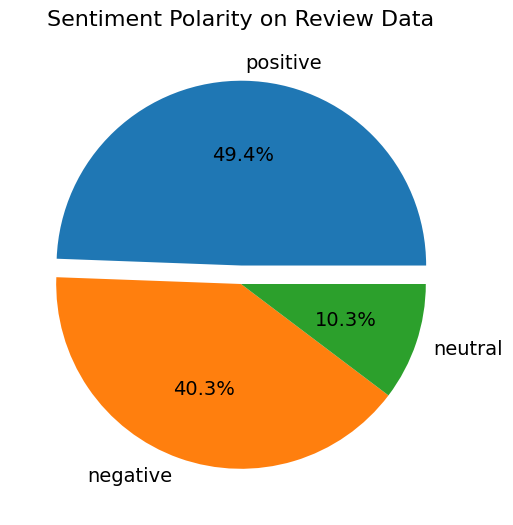

In [ ]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci.
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'df_gojek_reviews_cleaned' dan menyimpannya dalam list 'sizes'.
sizes = [count for count in df_gojek_reviews_cleaned['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'df_gojek_reviews_cleaned' dan menyimpannya dalam list 'labels'.
labels = list(df_gojek_reviews_cleaned['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.1 artinya potongan pertama akan sedikit terpisah).
explode = (0.1, 0, 0)

# Membuat pie chart dengan data 'sizes', 'labels', dan 'explode' yang telah ditentukan.
# Autopct digunakan untuk menampilkan persentase di dalam setiap potongan pie.
# Textprops digunakan untuk mengatur ukuran font teks dalam pie chart.
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})

# Menetapkan judul untuk pie chart dengan ukuran font dan jarak (padding) tertentu.
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart.
plt.show()

In [ ]:
# Mengatur opsi tampilan Pandas agar kolom dapat menampilkan teks hingga 5000 karakter.
pd.set_option('display.max_colwidth', 5000)

# Fungsi untuk memproses tweet berdasarkan polaritas
def process_tweets(df, sentiment):
    filtered_tweets = df[df['polarity'] == sentiment][['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
    filtered_tweets = filtered_tweets.sort_values(by='polarity_score', ascending=False).reset_index(drop=True)
    filtered_tweets.index += 1
    return filtered_tweets

# Membuat DataFrame untuk setiap kategori sentimen
positive_tweets = process_tweets(df_gojek_reviews_cleaned, 'positive')
negative_tweets = process_tweets(df_gojek_reviews_cleaned, 'negative')
neutral_tweets = process_tweets(df_gojek_reviews_cleaned, 'neutral')

In [ ]:
def generate_wordcloud(dataframe, title):
    """
    Fungsi untuk membuat dan menampilkan word cloud dari kolom 'text_stopword' dalam DataFrame.

    Parameters:
        dataframe (pd.DataFrame): DataFrame yang berisi teks yang telah dibersihkan.
        title (str): Judul untuk word cloud.
    """
    list_words = ' '.join([' '.join(tweet) for tweet in dataframe['text_stopword']])

    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title, fontsize=18)
    ax.grid(False)
    ax.imshow(wordcloud)
    ax.axis('off')
    fig.tight_layout(pad=0)
    plt.show()

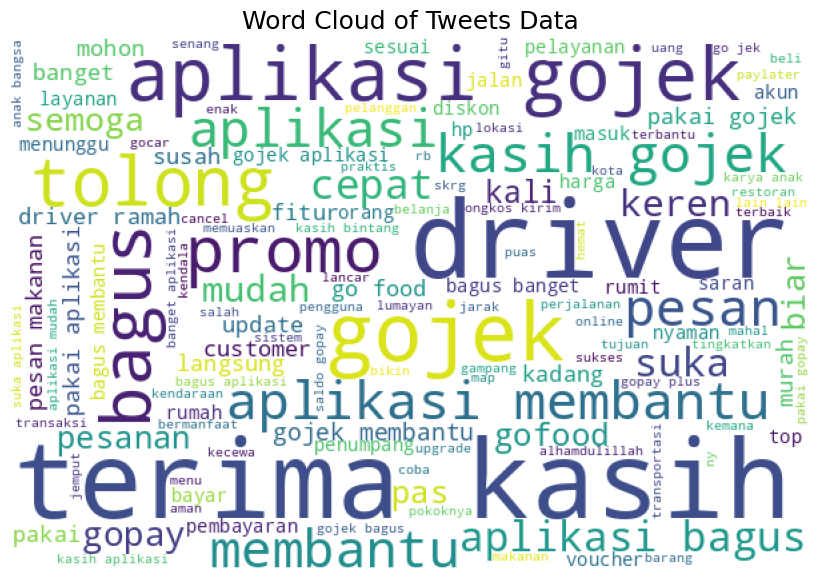

In [ ]:
# Menampilkan word cloud untuk semua tweet, tweet negatif, dan tweet positif
generate_wordcloud(df_gojek_reviews_cleaned, 'Word Cloud of Tweets Data')

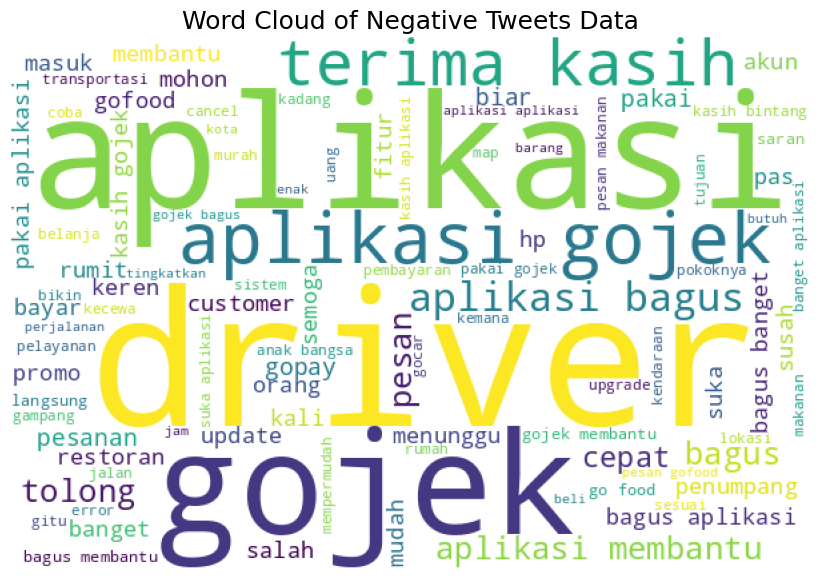

In [ ]:
generate_wordcloud(negative_tweets, 'Word Cloud of Negative Tweets Data')

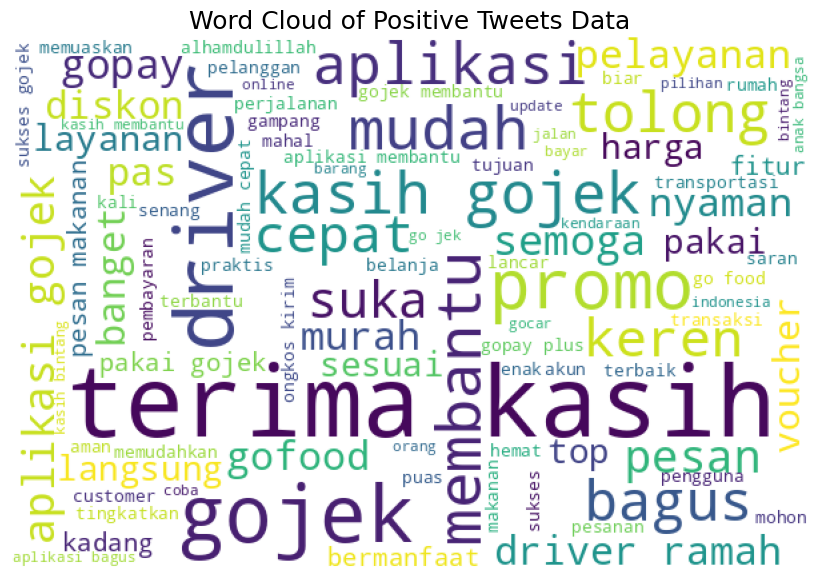

In [ ]:
generate_wordcloud(positive_tweets, 'Word Cloud of Positive Tweets Data')

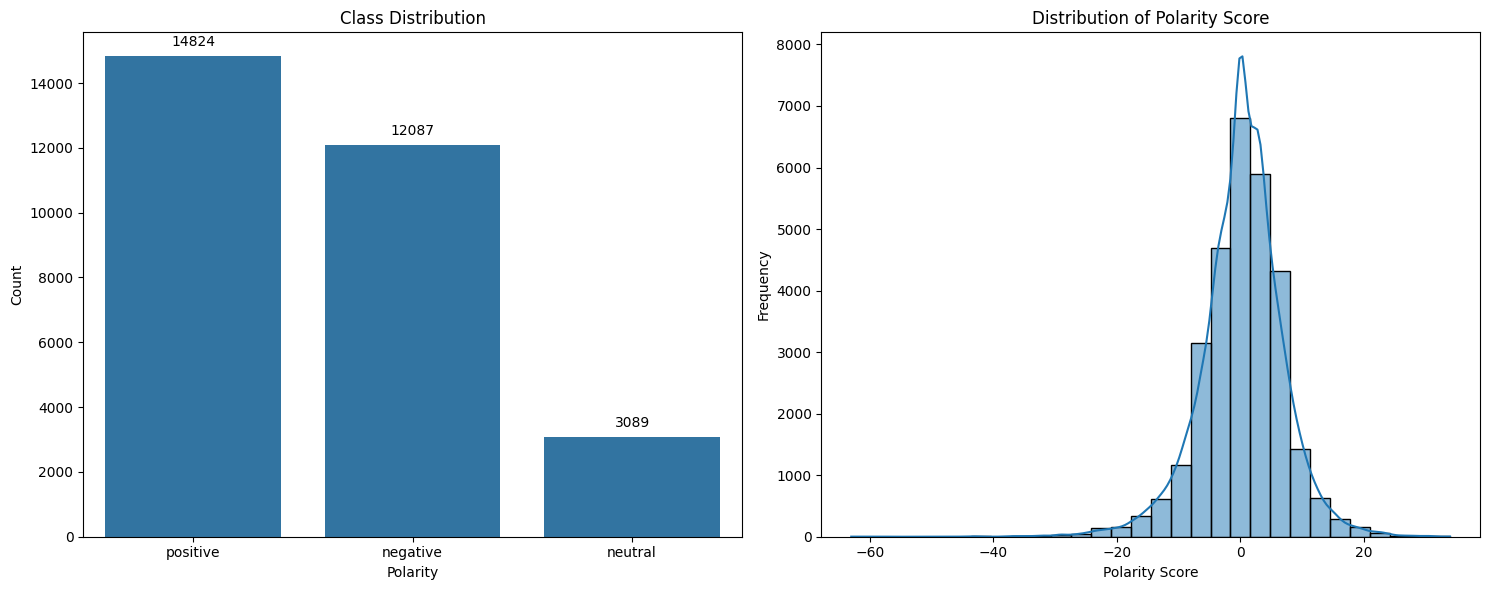

In [ ]:
# Buat figure dan axis untuk menampilkan 2 plot sejajar
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot distribusi kelas
sns.countplot(x='polarity', data=df_gojek_reviews_cleaned, ax=axes[0])
axes[0].set_title('Class Distribution')
axes[0].set_xlabel('Polarity')
axes[0].set_ylabel('Count')

# Menambahkan label jumlah data di atas tiap batang
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

# Plot distribusi polarity_score
sns.histplot(df_gojek_reviews_cleaned['polarity_score'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Polarity Score')
axes[1].set_xlabel('Polarity Score')
axes[1].set_ylabel('Frequency')

# Menampilkan plot
plt.tight_layout()
plt.show()

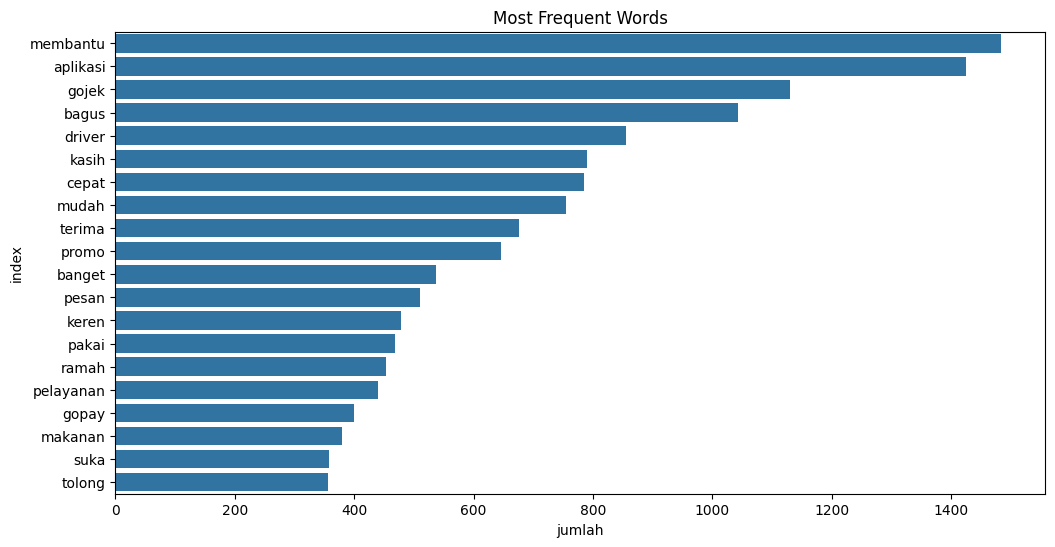

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize most frequent words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_gojek_reviews_cleaned['text_akhir'])

# Konversi hasil ekstraksi fitur menjadi dataframe
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df = tfidf_df.sum().reset_index(name='jumlah')
tfidf_df = tfidf_df.sort_values('jumlah', ascending=False).head(20)

sns.barplot(x='jumlah', y='index', data=tfidf_df)
plt.title('Most Frequent Words')
plt.show()

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Visualize text length distribution
df_gojek_reviews_cleaned['text_length'] = df_gojek_reviews_cleaned['text_akhir'].apply(lambda x: len(x.split()))
sns.histplot(df_gojek_reviews_cleaned['text_length'])
plt.title('Text Length Distribution')
plt.show()

## **Data Splitting**

In [ ]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = df_gojek_reviews_cleaned['text_akhir']

labelencoder = LabelEncoder()
y = labelencoder.fit_transform(df_gojek_reviews_cleaned['polarity'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Bisa juga 'val_accuracy'
    patience=5,          # Berhenti jika tidak ada peningkatan selama 5 epoch
    restore_best_weights=True
)

# lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

class CustomLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs and logs.get('val_accuracy') > 0.90:
            print(f"\n🎉 Model mencapai val_accuracy {logs['val_accuracy']:.4f} pada epoch {epoch+1}")
            self.model.stop_training = True
custom_logger = CustomLogger()

## **Modelling**

### **Skema 1 - Model LSTM dengan (80/20 split)**

In [ ]:
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Mengecek shape dari setiap dataset
print("Shape X_train_LSTM:", X_train_LSTM.shape)
print("Shape X_test_LSTM:", X_test_LSTM.shape)

print("Shape y_train_LSTM:", y_train_LSTM.shape)
print("Shape y_test_LSTM:", y_test_LSTM.shape)

Shape X_train_LSTM: (24000,)
Shape X_test_LSTM: (6000,)
Shape y_train_LSTM: (24000,)
Shape y_test_LSTM: (6000,)


In [ ]:
# Preprocessing untuk model LSTM
max_words = 2500
max_len = 100
tokenizer_LSTM = Tokenizer(num_words=max_words)
tokenizer_LSTM.fit_on_texts(X_train_LSTM)

X_train_seq_LSTM = tokenizer.texts_to_sequences(X_train_LSTM)
X_test_seq_LSTM = tokenizer.texts_to_sequences(X_test_LSTM)

X_train_pad_LSTM = pad_sequences(X_train_seq_LSTM, maxlen=max_len)
X_test_pad_LSTM = pad_sequences(X_test_seq_LSTM, maxlen=max_len)

# Konversi label ke one-hot encoding
y_train_cat_LSTM = pd.get_dummies(y_train_LSTM).values
y_test_cat_LSTM = pd.get_dummies(y_test_LSTM).values

In [ ]:
# Membangun model LSTM
model_LSTM = Sequential()
model_LSTM.add(Embedding(max_words, 256, input_length=max_len))
model_LSTM.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), return_sequences=True))
model_LSTM.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
model_LSTM.add(Dense(128, activation='relu'))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(3, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_LSTM = model_LSTM.fit(X_train_pad_LSTM, y_train_cat_LSTM, epochs=50, batch_size=batch_size, verbose=2,
                              callbacks=[early_stopping], validation_data=(X_test_pad_LSTM, y_test_cat_LSTM))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
12/12 - 136s - 11s/step - accuracy: 0.5142 - loss: 5.3380 - val_accuracy: 0.5448 - val_loss: 4.4190
Epoch 2/50
12/12 - 135s - 11s/step - accuracy: 0.5743 - loss: 3.8325 - val_accuracy: 0.6688 - val_loss: 3.1365
Epoch 3/50
12/12 - 142s - 12s/step - accuracy: 0.6960 - loss: 2.6979 - val_accuracy: 0.7385 - val_loss: 2.1966
Epoch 4/50
12/12 - 139s - 12s/step - accuracy: 0.7563 - loss: 1.9081 - val_accuracy: 0.7790 - val_loss: 1.5833
Epoch 5/50
12/12 - 143s - 12s/step - accuracy: 0.8022 - loss: 1.3654 - val_accuracy: 0.8387 - val_loss: 1.1472
Epoch 6/50
12/12 - 140s - 12s/step - accuracy: 0.8416 - loss: 0.9989 - val_accuracy: 0.8528 - val_loss: 0.8799
Epoch 7/50
12/12 - 142s - 12s/step - accuracy: 0.8695 - loss: 0.7486 - val_accuracy: 0.8770 - val_loss: 0.6805
Epoch 8/50
12/12 - 155s - 13s/step - accuracy: 0.8892 - loss: 0.5821 - val_accuracy: 0.8907 - val_loss: 0.5586
Epoch 9/50
12/12 - 152s - 13s/step - accuracy: 0.8990 - loss: 0.4777 - val_accuracy: 0.8857 - val_loss: 0.5043
E

In [ ]:
# Evaluasi model
score_LSTM, acc_LSTM = model_LSTM.evaluate(X_test_pad_LSTM, y_test_cat_LSTM, verbose=2)
print("Test score: %.4f" % (score_LSTM))
print("Test accuracy: %.2f" % (acc_LSTM))

188/188 - 14s - 72ms/step - accuracy: 0.9205 - loss: 0.3102
Test score: 0.3102
Test accuracy: 0.92


In [ ]:
# Evaluasi dengan classification report
y_pred_prob = model_LSTM.predict(X_test_pad_LSTM)   # Prediksi probabilitas kelas dari model
y_pred_LSTM = np.argmax(y_pred_prob, axis=1)         # Mengambil indeks dengan probabilitas tertinggi
y_true_LSTM = np.argmax(y_test_cat_LSTM, axis=1)          # Konversi one-hot encoding ke label asli

accuracy_LSTM = accuracy_score(y_true_LSTM, y_pred_LSTM)
precision_LSTM = precision_score(y_true_LSTM, y_pred_LSTM, average='weighted')
recall_LSTM = recall_score(y_true_LSTM, y_pred_LSTM, average='weighted')
f1_LSTM = f1_score(y_true_LSTM, y_pred_LSTM, average='weighted')

print("🛑 EVALUASI MODEL LSTM")
print("=====================================================")
print(f"Accuracy: {accuracy_LSTM:.2f}")
print(f"Precision: {precision_LSTM:.2f}")
print(f"Recall: {recall_LSTM:.2f}")
print(f"F1 Score: {f1_LSTM:.2f}\n")

print("🛑 CLASSIFICATION REPORT")
print("=====================================================")
print(classification_report(y_true_LSTM, y_pred_LSTM, target_names=['negative', 'neutral', 'positive']))
print("=====================================================")
print("*LSTM - Akurasi pada data latih: %.4f" % (history_LSTM.history['accuracy'][-1]))
print("*LSTM - Akurasi pada data uji: %.4f" % (acc_LSTM))
print("=====================================================")

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step
🛑 EVALUASI MODEL LSTM
Accuracy: 0.63
Precision: 0.63
Recall: 0.63
F1 Score: 0.63

🛑 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    negative       0.62      0.66      0.64       604
     neutral       0.35      0.37      0.36       155
    positive       0.69      0.65      0.67       741

    accuracy                           0.63      1500
   macro avg       0.56      0.56      0.56      1500
weighted avg       0.63      0.63      0.63      1500

*LSTM - Akurasi pada data latih: 0.9622
*LSTM - Akurasi pada data uji: 0.9205


### Skema 2 - Model GRU dengan (95/5 split)

In [ ]:
X_train_GRU, X_test_GRU, y_train_GRU, y_test_GRU = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [ ]:
# Mengecek shape dari setiap dataset
print("Shape X_train_GRU:", X_train_GRU.shape)
print("Shape X_test_GRU:", X_test_GRU.shape)

print("Shape y_train_GRU:", y_train_GRU.shape)
print("Shape y_test_GRU:", y_test_GRU.shape)

Shape X_train_GRU: (28500,)
Shape X_test_GRU: (1500,)
Shape y_train_GRU: (28500,)
Shape y_test_GRU: (1500,)


In [ ]:
# Preprocessing untuk model LSTM
max_words = 2500
max_len = 100
tokenizer_GRU = Tokenizer(num_words=max_words)
tokenizer_GRU.fit_on_texts(X_train_GRU)

X_train_seq_GRU = tokenizer_GRU.texts_to_sequences(X_train_GRU)
X_test_seq_GRU = tokenizer_GRU.texts_to_sequences(X_test_GRU)

X_train_pad_GRU = pad_sequences(X_train_seq_GRU, maxlen=max_len)
X_test_pad_GRU = pad_sequences(X_test_seq_GRU, maxlen=max_len)

# Konversi label ke one-hot encoding
y_train_cat_GRU = pd.get_dummies(y_train_GRU).values
y_test_cat_GRU = pd.get_dummies(y_test_GRU).values

In [ ]:
# Membangun model GRU
model_GRU = Sequential()
model_GRU.add(Embedding(max_words, 512, input_length=max_len))
model_GRU.add(SpatialDropout1D(0.3))
model_GRU.add(Bidirectional(GRU(64, return_sequences=True)))
model_GRU.add(Bidirectional(GRU(128, return_sequences=False)))
model_GRU.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(3, activation='softmax'))
model_GRU.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 1028
history_GRU = model_GRU.fit(X_train_pad_GRU, y_train_cat_GRU, epochs=50, batch_size=batch_size, verbose=2,
                            validation_data=(X_test_pad_GRU, y_test_cat_GRU),callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Evaluasi model
score_GRU, acc_GRU = model_GRU.evaluate(X_test_pad_GRU, y_test_cat_GRU, verbose=2)
print("Test score: %.4f" % (score_GRU))
print("Test accuracy: %.2f" % (acc_GRU))

In [ ]:
# Evaluasi dengan classification report untuk GRU
y_pred_prob_GRU = model_GRU.predict(X_test_pad_GRU)
y_pred_GRU = np.argmax(y_pred_prob_GRU, axis=1)
y_true_GRU = np.argmax(y_test_cat_GRU, axis=1)

accuracy_GRU = accuracy_score(y_true_GRU, y_pred_GRU)
precision_GRU = precision_score(y_true_GRU, y_pred_GRU, average='weighted')
recall_GRU = recall_score(y_true_GRU, y_pred_GRU, average='weighted')
f1_GRU = f1_score(y_true_GRU, y_pred_GRU, average='weighted')

print("🛑 EVALUASI MODEL GRU")
print("=====================================================")
print(f"Accuracy: {accuracy_GRU:.2f}")
print(f"Precision: {precision_GRU:.2f}")
print(f"Recall: {recall_GRU:.2f}")
print(f"F1 Score: {f1_GRU:.2f}\n")

print("🛑 CLASSIFICATION REPORT")
print("=====================================================")
print(classification_report(y_true_GRU, y_pred_GRU, target_names=['negative', 'neutral', 'positive']))
print("=====================================================")
print("*GRU - Akurasi pada data latih: %.4f" % (history_GRU.history['accuracy'][-1]))
print("*GRU - Akurasi pada data uji: %.4f" % (accuracy_GRU))
print("=====================================================")

### Model CNN

In [ ]:
X_train_CNN, X_test_CNN, y_train_CNN, y_test_CNN = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [ ]:
# Mengecek shape dari setiap dataset
print("Shape X_train_CNN:", X_train_CNN.shape)
print("Shape X_test_CNN:", X_test_CNN.shape)

print("Shape y_train_CNN:", y_train_CNN.shape)
print("Shape y_test_CNN:", y_test_CNN.shape)

In [ ]:
# Preprocessing untuk model LSTM
max_words = 2500
max_len = 100
tokenizer_CNN = Tokenizer(num_words=max_words)
tokenizer_CNN.fit_on_texts(X_train_CNN)

X_train_seq_CNN = tokenizer_CNN.texts_to_sequences(X_train_CNN)
X_test_seq_CNN = tokenizer_CNN.texts_to_sequences(X_test_CNN)

X_train_pad_CNN = pad_sequences(X_train_seq_CNN, maxlen=max_len)
X_test_pad_CNN = pad_sequences(X_test_seq_CNN, maxlen=max_len)

# Konversi label ke one-hot encoding
y_train_cat_CNN = pd.get_dummies(y_train_CNN).values
y_test_cat_CNN = pd.get_dummies(y_test_CNN).values

In [ ]:
# Membangun model CNN
model_CNN = Sequential()
model_CNN.add(Embedding(max_words, 512, input_length=max_len))
model_CNN.add(Conv1D(64, kernel_size=5, activation='relu'))
model_CNN.add(MaxPooling1D(pool_size=2))
model_CNN.add(Flatten())
model_CNN.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.5))
model_CNN.add(Dense(3, activation='softmax'))
model_CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Melatih model dengan early stopping kustom
batch_size = 2056
history_CNN = model_CNN.fit(X_train_pad_CNN, y_train_cat_CNN, epochs=50, batch_size=batch_size, verbose=2,
                            callbacks=[early_stopping], validation_data=(X_test_pad_CNN, y_test_cat_CNN))

In [ ]:
# Evaluasi model
score_CNN, acc_CNN = model_CNN.evaluate(X_test_pad_CNN, y_test_cat_CNN, verbose=2,batch_size=1028)
print("Test score: %.4f" % (score_CNN))
print("Test accuracy: %.4f" % (acc_CNN))

In [ ]:
# Evaluasi dengan classification report untuk CNN
y_pred_prob_CNN = model_CNN.predict(X_test_pad_CNN)
y_pred_CNN = np.argmax(y_pred_prob_CNN, axis=1)
y_true_CNN = np.argmax(y_test_cat_CNN, axis=1)

accuracy_CNN = accuracy_score(y_true_CNN, y_pred_CNN)
precision_CNN = precision_score(y_true_CNN, y_pred_CNN, average='weighted')
recall_CNN = recall_score(y_true_CNN, y_pred_CNN, average='weighted')
f1_CNN = f1_score(y_true_CNN, y_pred_CNN, average='weighted')

print("🛑 EVALUASI MODEL CNN")
print("=====================================================")
print(f"Accuracy: {accuracy_CNN:.2f}")
print(f"Precision: {precision_CNN:.2f}")
print(f"Recall: {recall_CNN:.2f}")
print(f"F1 Score: {f1_CNN:.2f}\n")

print("🛑 CLASSIFICATION REPORT")
print("=====================================================")
print(classification_report(y_true_CNN, y_pred_CNN, target_names=['negative', 'neutral', 'positive']))
print("=====================================================")
print("*CNN - Akurasi pada data latih: %.4f" % (history_CNN.history['accuracy'][-1]))
print("*CNN - Akurasi pada data uji: %.4f" % (accuracy_CNN))
print("=====================================================")


In [ ]:
results_df = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'CNN'],
    'Accuracy Train ': [history_LSTM.history['accuracy'][-1], history_GRU.history['accuracy'][-1],history_CNN.history['accuracy'][-1]],
    'Accuracy Test': [acc_LSTM, acc_GRU, acc_CNN]
})

results_df.round(4)

In [ ]:
# Visualisasi Loss dan Accuracy untuk Ketiga Model
models = ['LSTM', 'GRU', 'CNN']
histories = [history_LSTM, history_GRU, history_CNN]

plt.figure(figsize=(12, 8))

for i, (model, history) in enumerate(zip(models, histories)):
    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss During Training - {model}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy During Training - {model}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

## **Testing**

In [ ]:
# Contoh data baru
new_texts = [
    "Driver sangat ramah dan perjalanan terasa nyaman, saya sangat puas sehingga saya memberikan bintang lima!",
    "Driver sangat tidak sopan dengan membatalkan pesanan mendadak.",
    "Lokasi saya tidak terdeteksi oleh driver."
]

# Nilai asli dari teks
true_labels = ["positive", "negative", "neutral"]

# Tokenisasi teks baru
new_sequences_LSTM = tokenizer_LSTM.texts_to_sequences(new_texts)
new_sequences_GRU = tokenizer_GRU.texts_to_sequences(new_texts)
new_sequences_CNN = tokenizer_CNN.texts_to_sequences(new_texts)

# Padding sequences dengan max_len masing-masing model
new_padded_LSTM = pad_sequences(new_sequences_LSTM, maxlen=max_len)
new_padded_GRU = pad_sequences(new_sequences_GRU, maxlen=max_len)
new_padded_CNN = pad_sequences(new_sequences_CNN, maxlen=max_len)

# Membuat prediksi untuk setiap model
predictions_LSTM = model_LSTM.predict(new_padded_LSTM)
predictions_GRU = model_GRU.predict(new_padded_GRU)
predictions_CNN = model_CNN.predict(new_padded_CNN)

# Mengubah probabilitas ke indeks kelas tertinggi
predicted_labels_LSTM = np.argmax(predictions_LSTM, axis=1)
predicted_labels_GRU = np.argmax(predictions_GRU, axis=1)
predicted_labels_CNN = np.argmax(predictions_CNN, axis=1)

# Konversi indeks ke label asli
predicted_labels_LSTM = labelencoder.inverse_transform(predicted_labels_LSTM)
predicted_labels_GRU = labelencoder.inverse_transform(predicted_labels_GRU)
predicted_labels_CNN = labelencoder.inverse_transform(predicted_labels_CNN)

# Menampilkan hasil prediksi dengan angka probabilitas
for i, (text, true_label, label_LSTM, label_GRU, label_CNN) in enumerate(zip(new_texts, true_labels,
                                                                             predicted_labels_LSTM,
                                                                             predicted_labels_GRU,
                                                                             predicted_labels_CNN)):
    print(f"Text: {text}")
    print(f"True Label: {true_label}")

    print(f"Predicted Label (LSTM): {label_LSTM} - Probabilities: {predictions_LSTM[i]}")
    print(f"Predicted Label (GRU): {label_GRU} - Probabilities: {predictions_GRU[i]}")
    print(f"Predicted Label (CNN): {label_CNN} - Probabilities: {predictions_CNN[i]}")
